In [ ]:
import os
import copy
from tqdm import tqdm
import pandas as pd
from typing import Union, List

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModel,
    AutoTokenizer,
    get_linear_schedule_with_warmup)
from transformers.modeling_outputs import SequenceClassifierOutput

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
class VacData(Dataset):
    def __init__(self, file_path, model_name, max_length=128, min_length=7):
        self.data = pd.read_csv(file_path)
        self.data = self.data[self.data['description_1'].apply(lambda x: len(str(x).split()) >= min_length)]
        self.data = self.data.reset_index(drop=True)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_length = max_length

        unique_labels = self.data['target'].unique()
        self.label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
        self.id_to_label = {idx: label for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.loc[index, 'description_1']
        label = self.data.loc[index, 'target']

        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        inputs['labels'] = torch.tensor(self.encode_label(label))

        return inputs

    def encode_label(self, label):
        if label < .22:
            return 0
        elif .22 < label < .44:
            return 1
        else:
            return 2

    def decode_label(self, label_id):
        return self.id_to_label[label_id]

In [ ]:
### This is just an interface example. You may change it if you want.
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], dataset: VacData):
        super().__init__()
        if isinstance(base_transformer_model, str):
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
        else:
            self.backbone = base_transformer_model

        # self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, len(dataset.label_to_id))

    def forward(self, inputs):
        outputs = self.backbone(inputs['input_ids'], attention_mask=inputs['attention_mask'])
        pooler_output = outputs.pooler_output
        # pooler_output = self.dropout(pooler_output)
        logits = self.classifier(pooler_output)

        # return {'logits': logits}
        return SequenceClassifierOutput(loss=None, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

    @staticmethod
    def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        return model, optimizer, scheduler

In [ ]:
def create_data_loader(file_path, model_name, batch_size=16, max_length=128, min_length=7):
    dataset = VacData(file_path, model_name, max_length=max_length, min_length=7)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader, dataset

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer, scheduler):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)

In [ ]:
def evaluate(model, dataset):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataset:
            inputs = {'input_ids': batch['input_ids'].to(device), 'attention_mask': batch['attention_mask'].to(device)}
            outputs = model(inputs)
            logits = outputs.logits
            labels = batch['labels'].to(device)

            _, predicted = torch.max(logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
def train_transformer(transformer_model, dataset, freeze_backbone=True, epochs=15, learning_rate=1e-5, warmup_steps=0, max_steps=None, save_dir='./checkpoints', checkpoint_path=None):
    torch.cuda.empty_cache()
    model = copy.deepcopy(transformer_model)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    if freeze_backbone:
        model = freeze_backbone_function(model)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []

    total_steps = len(dataset) * epochs
    if max_steps is not None:
        total_steps = min(total_steps, max_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
    )

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if checkpoint_path is not None:
        model, optimizer, scheduler = TransformerClassificationModel.load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        print(f"Loading model from checkpoint: {checkpoint_path}")

    if freeze_backbone:
        model = freeze_backbone_function(model)

    for epoch in range(epochs):
        epoch_train_loss = 0
        model.train()
        for batch in tqdm(dataset):
            optimizer.zero_grad()
            inputs = {'input_ids': batch['input_ids'].squeeze(1).to(device), 'attention_mask': batch['attention_mask'].squeeze(1).to(device)}
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_train_loss += loss.item()

        epoch_train_loss /= len(dataset)
        train_losses.append(epoch_train_loss)

        checkpoint_path = os.path.join(save_dir, f'epoch_{epoch + 1}.pth')
        save_checkpoint(checkpoint_path, model, optimizer, scheduler)
        print(f"Model saved to: {checkpoint_path}")

    torch.cuda.empty_cache()
    return model, optimizer, scheduler, train_losses

In [ ]:
file_path = '/content/gdrive/MyDrive/Colab Notebooks/vacancies/clean_data.csv'
batch_size = 16
max_length = 128
min_length = 7

In [ ]:
model_name = 'cointegrated/rubert-tiny2'

rubert_tiny_loader, rubert_tiny_dataset = create_data_loader(file_path, model_name, batch_size, max_length, min_length)
rubert_tiny_model = TransformerClassificationModel(model_name, rubert_tiny_dataset)

In [ ]:
rubert_tiny_full_finetuned, rubert_tiny_full_optimizer, rubert_tiny_full_scheduler, rubert_tiny_full_losses = train_transformer(rubert_tiny_model,
                                                                                                                                    rubert_tiny_loader,
                                                                                                                                    freeze_backbone=False,
                                                                                                                                    epochs=15,
                                                                                                                                    learning_rate=1e-5,
                                                                                                                                    warmup_steps=int(len(rubert_tiny_loader) * 0.1),
                                                                                                                                    max_steps=None,
                                                                                                                                    save_dir='/content/gdrive/MyDrive/Colab Notebooks/vacancies',
                                                                                                                                    checkpoint_path=None
                                                                                                                                )

100%|██████████| 74/74 [00:04<00:00, 16.26it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_1.pth


100%|██████████| 74/74 [00:03<00:00, 21.56it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_2.pth


100%|██████████| 74/74 [00:03<00:00, 21.71it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_3.pth


100%|██████████| 74/74 [00:04<00:00, 15.71it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_4.pth


100%|██████████| 74/74 [00:03<00:00, 20.09it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_5.pth


100%|██████████| 74/74 [00:04<00:00, 17.87it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_6.pth


100%|██████████| 74/74 [00:04<00:00, 16.30it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_7.pth


100%|██████████| 74/74 [00:03<00:00, 18.93it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_8.pth


100%|██████████| 74/74 [00:03<00:00, 19.77it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_9.pth


100%|██████████| 74/74 [00:03<00:00, 21.10it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_10.pth


100%|██████████| 74/74 [00:04<00:00, 15.17it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_11.pth


100%|██████████| 74/74 [00:03<00:00, 20.21it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_12.pth


100%|██████████| 74/74 [00:05<00:00, 14.35it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_13.pth


100%|██████████| 74/74 [00:03<00:00, 20.02it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_14.pth


100%|██████████| 74/74 [00:04<00:00, 18.15it/s]


Model saved to: /content/gdrive/MyDrive/Colab Notebooks/vacancies/epoch_15.pth


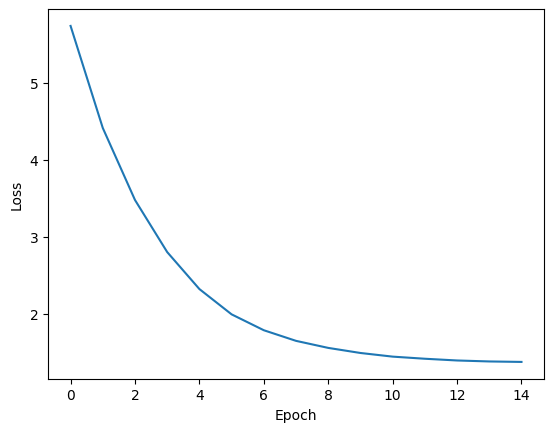

In [ ]:
plt.plot(rubert_tiny_full_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
def draw_first_layer_attention_heads(text: str, model: TransformerClassificationModel,
                                     max_tokens: int = None, color_palette: str = 'viridis'):
    tokenizer = AutoTokenizer.from_pretrained(model.backbone.config._name_or_path)
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(next(model.parameters()).device)

    with torch.no_grad():
        outputs = model.backbone(input_ids, output_attentions=True)
        attention_scores = outputs.attentions[0]

    attention_scores = attention_scores.cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids.cpu().numpy()[0])

    if max_tokens is not None:
        attention_scores = attention_scores[:, :, :max_tokens, :max_tokens]
        tokens = tokens[:max_tokens]

    num_heads = model.backbone.config.num_attention_heads
    fig, axs = plt.subplots(nrows=num_heads, ncols=1, figsize=(20, 10 * num_heads))

    for i in range(num_heads):
        sns.heatmap(attention_scores[0, i], xticklabels=tokens, yticklabels=tokens, cbar=False, cmap=color_palette, ax=axs[i], square=True)
        axs[i].set_title(f'Head {i}')

    plt.show()


In [ ]:
data = pd.read_csv(file_path)
sample_texts = data['description_1'].head(2)

школа it Наш стек: Python, fastapi, postgres, gitlabПожелания:- Опыт использования одного из фреймворков/библиотек для написания сервисов на RESTful API- Понимание как работает асинхронность и многопоточность в Python- Знание основ Git- Базовое знание SQLОсновные требования к ребятам, которые хотели бы пройти практику в школе IT - это:- 8+ месяцев обучения на соответсвующем направлении- Один или несколько законченных pet проектовОстальные требования - это больше пожелания, нежели твердые требования. Если человек закончил 8-12 месяцев обучения, то он скорее всего уже успел познакомиться с перечисленным выше стеком (на поверхностном уровне)Техническое задание и интервьюШкола бесплатна и сотрудничает с фондами.Стажировка не оплачивается участникам.В конце проекта ты сразу сможешь пополнить им своё портфолио. Проект будет реализован людьми для людей.


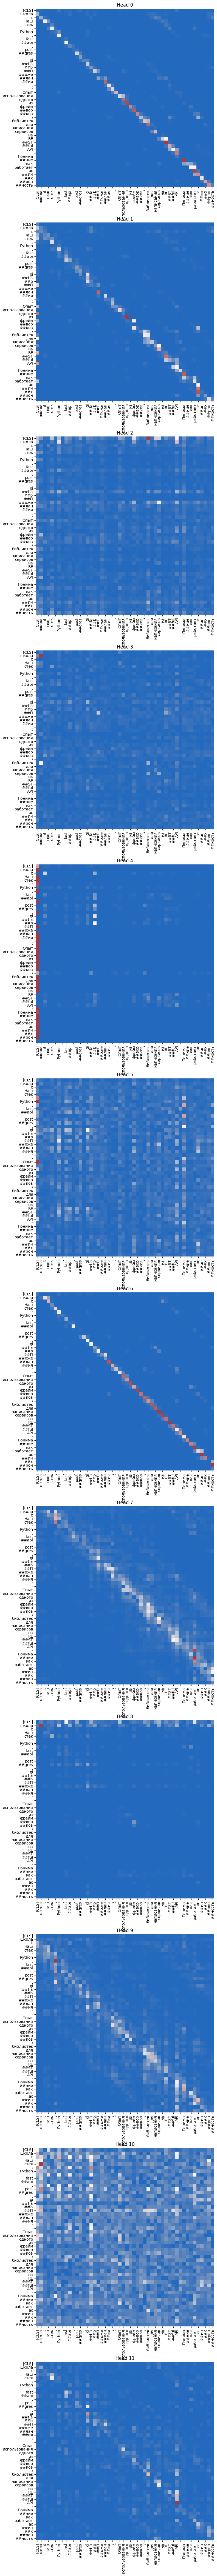

symbioway 1) Широкий IT-кругозор, понимание, какие бывают языки программирования и для чего они используются.2) Владение хотя быть одним современным языком программирования (Java, Python, PHP, C#, Go, JavaScript и/или C++), желательно знание на базовом уровне языка запросов SQL и базовые навыки вёрстки веб-страниц (HTML/CSS).3) Свободное владение разговорным английским языком.4) Системность, аналитический склад ума и умение чувствовать других людей.5) Желание и готовность проводить собеседования и оценивать специалистов или 1) тестовое задание2) онлайн собеседование с менеджером проектов3) онлайн собеседование с СОО или СЕОставка 750 рублей - за 1 обработанного кандидата (проведено собеседование + написано заключение по нему) Полная удаленкаОбучение


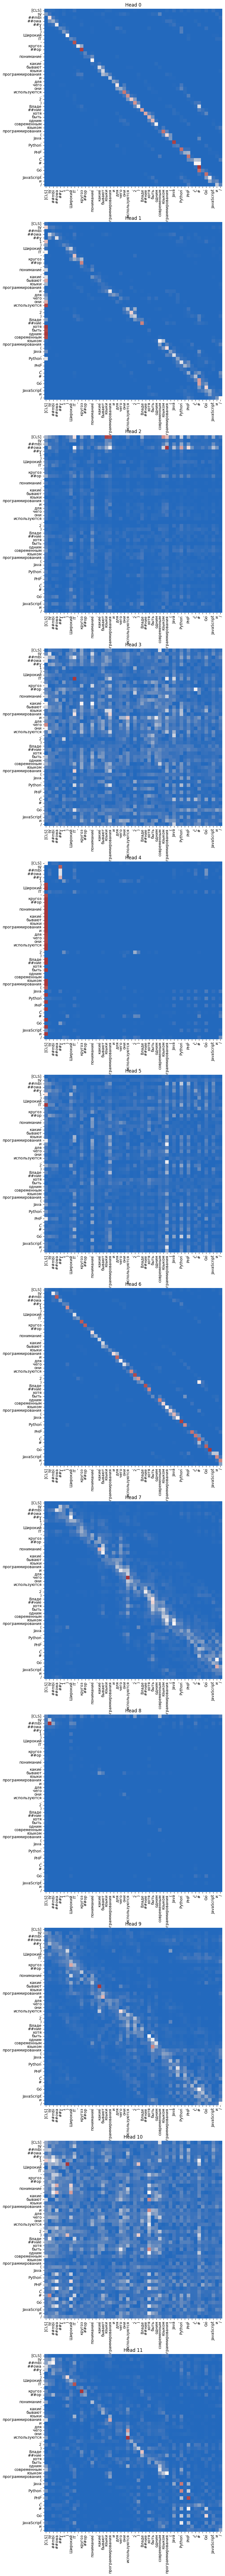

In [ ]:
for text in sample_texts:
    print(text)
    draw_first_layer_attention_heads(text, rubert_tiny_full_finetuned, max_tokens=50, color_palette='vlag')